# Graph Neural Networks, an introduction, part 4: Graph Convolutional Networks
In the [previous post](03-mpnn.md), we came across concept of MPNN. There is only one theoretical step is left before we can get our hands dirty, and that concept is GCN.

# GCN Goal
- Learn a function of signals/features on a graph $\mathcal{G}=(\mathcal{V}, \mathcal{E})$ and classify vertices according to some node label. The function  takes as input:
 - A feature description $x_i$ for every node $i$; summarized in a $N\times D$ feature matrix $X$ ($N$: number of nodes, $D$: number of input features)
 - A representative description of the graph structure in matrix form; typically in the form of an adjacency matrix A (or some function thereof)
 
and produces a node-level output $Z$ (an $N\times F$ feature matrix, where F is the number of output features per node).

# How is it done?
- Take the input
- Sequentially process through hidden layers, which are intermediate feature representation of a neural network.
- Flatten the representations into the softmax probability distribution over labels.
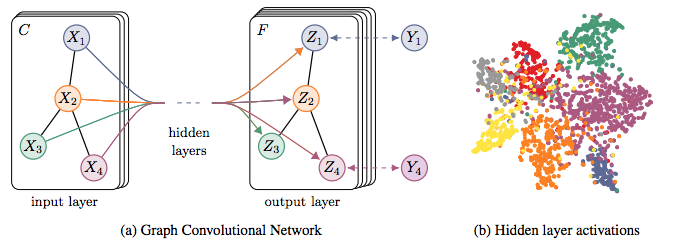

# Hidden Layers
- $H^{(l+1)}=f(H^{(l)}, A)$, where 
 - $A$ is the adjacency matrix.
 - $H^{0} = X$
 - $H^{(L)} = Z$

# Propagation Rule
- $f(H^{(l)}, A) = \sigma(AH^{(l)}W^{(l)})$, where
- $W^{(l)}$ is the weight matrix for l-th layer
- $\sigma(.)$ is an activation function such as $ReLU$

# Issues with Propagation Rule
- it taken into account features of nodes that are connected to the node that is in focus and ignores features of the node itself. This problem can be solved by adding self loop to $A$. To do that we construct $\tilde{A} = I + A$
- Nodes with high degree can change the scale off feature vector. To solve the issuer we use Normalized Laplacian.
- The new propagation rule is: 
$$
f(H^{(l)}, A) = \sigma(\tilde{D}^\frac{-1}{2}\tilde{A}\tilde{D}^\frac{-1}{2}H^{(l)}W^{(l)})
$$

# Loss
- label information is smoothed over the graph via some form of explicit graph-based regularization.
$$
\mathcal{L}=\mathcal{L_0}+\mathcal{L_{reg}}, where
$$
$$
\mathcal{L_{reg}} = \sum_{i,j}A_{ij}\|f(X_i)=f(X_j)\|^2=f(X)^T \Delta f(X)
$$
- The training is performed only on supervised loss, $\mathcal(L)_0$, the labeled part of the graph.
- $f(.)$ can be a neural network-like differantiable function.



# Reference:
- [https://arxiv.org/pdf/1609.02907.pdf](https://arxiv.org/pdf/1609.02907.pdf)

# Hands-on Exercise

In [1]:
import networkx as nx
import random
import numpy as np
import math
import matplotlib.pyplot as plt

<ipython-input-2-5fd744cefb55>:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  G.remove_edges_from(random.sample(G.edges(),k=int(DROP_RATE*G.number_of_edges())))
<ipython-input-2-5fd744cefb55>:8: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  A = nx.adj_matrix(G).todense()
/Users/cyrusmv/minicond/envs/dgl/lib/python3.9/site-packages/networkx/linalg/graphmatrix.py:187: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return adjacency_matrix(G, nodelist, dtype, weight)


matrix([[0, 1, 1, 1],
        [1, 0, 1, 1],
        [1, 1, 0, 0],
        [1, 1, 0, 0]])

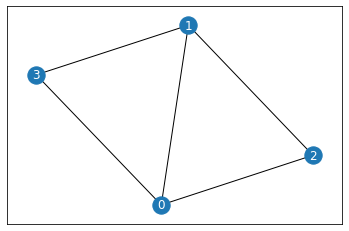

In [2]:
#defining a graph
random.seed(42)
N = 4
DROP_RATE=.25
G = nx.complete_graph(N)
G.remove_edges_from(random.sample(G.edges(),k=int(DROP_RATE*G.number_of_edges())))
nx.draw_networkx(G, with_labels=True, font_color='w')
A = nx.adj_matrix(G).todense()
A

In [3]:
#Creating attributes
X = np.matrix([[i, -i] for i in range(A.shape[0])], dtype=float)
X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])

In [4]:
#Simple propagation rule
A * X

matrix([[ 6., -6.],
        [ 5., -5.],
        [ 1., -1.],
        [ 1., -1.]])

In [5]:
#adding self loop
I = np.matrix(np.eye(A.shape[0]))
I

matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [6]:
A_hat = A + I
A_hat

matrix([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 0.],
        [1., 1., 0., 1.]])

In [7]:
A_hat * X

matrix([[ 6., -6.],
        [ 6., -6.],
        [ 3., -3.],
        [ 4., -4.]])

In [8]:
# Normalizing feature representation
D = np.array(np.sum(A, axis=0))[0]
D = np.matrix(np.diag(D))
D

matrix([[3, 0, 0, 0],
        [0, 3, 0, 0],
        [0, 0, 2, 0],
        [0, 0, 0, 2]])

In [9]:
# Transofrming adjacency matrix
A, D**-1 * A

(matrix([[0, 1, 1, 1],
         [1, 0, 1, 1],
         [1, 1, 0, 0],
         [1, 1, 0, 0]]),
 matrix([[0.        , 0.33333333, 0.33333333, 0.33333333],
         [0.33333333, 0.        , 0.33333333, 0.33333333],
         [0.5       , 0.5       , 0.        , 0.        ],
         [0.5       , 0.5       , 0.        , 0.        ]]))

In [10]:
#Applying propagation rule
D**-1 * A*X

matrix([[ 2.        , -2.        ],
        [ 1.66666667, -1.66666667],
        [ 0.5       , -0.5       ],
        [ 0.5       , -0.5       ]])

In [11]:
#Adding weights
D_hat = np.array(np.sum(A_hat, axis=0))[0]
W = np.matrix([
             [1, -1],
             [-1, 1]
         ])
D_hat**-1 * A_hat * X * W

matrix([[ 10.66666667, -10.66666667]])

In [12]:
W = np.matrix([
             [1],
             [-1]
         ])
D_hat**-1 * A_hat * X * W

matrix([[10.66666667]])

## What is next?
Next we implemnt a hello world example of interaction graphs or the [karate club](05-karate-club.md) using MPNN and GCN.